#INFO

- this notebook is a further preproccessingfor the images and the masks 
- some rows of the created studies.csv has the same different masks with the same mamograme
- we will merge these masks into one single mask
- then save it into a numpy array


**Imports**

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import cv2
import pandas as pd
from PIL import Image
from skimage.io import imread, imshow
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import keras

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dnnbreastcancer","key":"33e6cf853cd6597e98d848c0a11e6f82"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset -p /content/ --unzip

100% 4.95G/4.95G [00:55<00:00, 140MB/s]
100% 4.95G/4.95G [00:55<00:00, 96.1MB/s]


In [ ]:
DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"
studies = pd.read_csv(f'{DDSM_dir}/csv_mod/studies.csv')

#dropping rows that doesn't have ROI mask.
studies.dropna(subset = ['ROI_path'],inplace = True)
studies.info()

studies['mammogram_path']=studies.apply(lambda x: x['mammogram_path'].replace(DDSM_dir, '/content'),axis=1)
studies['ROI_path']=studies.apply(lambda x: x['ROI_path'].replace(DDSM_dir, '/content'),axis=1)
studies['cropped_path']=studies.apply(lambda x: x['cropped_path'].replace(DDSM_dir, '/content'),axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3568 entries, 0 to 3603
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3568 non-null   int64 
 1   StudyNo         3568 non-null   int64 
 2   M_ID            3568 non-null   object
 3   P_ID            3568 non-null   object
 4   mammogram_path  3568 non-null   object
 5   ROI_path        3568 non-null   object
 6   cropped_path    3568 non-null   object
 7   pathology       3568 non-null   object
dtypes: int64(2), object(6)
memory usage: 250.9+ KB


#Utils

**Function to plot the study rows**

In [ ]:
### Function definition ####
def plot_studies(Files):

  n = len(Files)

  fig, ax = plt.subplots(n, 3, figsize=(12, n*3))
  fig.subplots_adjust(hspace=0.3, wspace=0.01)
  plt.setp(ax, xticks=[], yticks=[])

  for i, row in tqdm(Files.reset_index().iterrows()):
    mamogram = cv2.resize(cv2.imread(row['mammogram_path']), dsize=(256,512))
    ax[i, 0].imshow(mamogram)
    if row['ROI_path'] is not None:
      roi = cv2.resize(cv2.imread(row['ROI_path'] ), dsize=(256,512))
      ax[i, 1].imshow(roi)

    if row['cropped_path'] is not None:
      cropped = cv2.resize(cv2.imread(row['cropped_path']), dsize=(256,512))
      ax[i, 2].imshow(cropped)

    ax[i, 1].set_title(row['pathology'], fontsize=12, y=-0.2)
    
  plt.show()

In [ ]:
def plot_numpy(images,masks,num_samples = 2):

  indices = np.random.choice(np.arange(images.shape[0]), size= num_samples, replace=False)

  for idx in indices:
        # Get data
        x = images[idx]
        y = masks[idx] # true mask

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot original image
        axs[0].imshow(x, cmap = 'gray')
        axs[0].set_title("Image")

        # Plot prediction
        axs[1].imshow(y, cmap='gray')
        axs[1].set_title("mask")

        # Hide the axes
        for ax in axs:
            ax.axis('off')

        plt.show()

In [ ]:
def plot_cropped_numpy(cropped,labels,num_samples = 2):
  import matplotlib.pyplot as plt

  indices = np.random.choice(np.arange(cropped.shape[0]), size= num_samples, replace=False)
  for idx in indices:
        # Get data
        x = cropped[idx]
        y = labels[idx] # true mask
        label_mapping_reverse = {0: 'BENIGN_WITHOUT_CALLBACK', 1: 'BENIGN', 2: 'MALIGNANT'}
        label_str = label_mapping_reverse[np.argmax(y)] 

        plt.imshow(x, cmap='gray')  # Use gray color map since these are grayscale images
        plt.title(label_str)
        plt.show()

#Segmentation Data and classification Data

spliting the data into classification data and segmentation data
such that the mams and masks are in a single dataframe 
the cropped images and the pathology are in different datatype


In [ ]:
st_classify = studies[['M_ID','cropped_path','pathology']].copy()
st_segment = studies[['M_ID','mammogram_path','ROI_path']].copy()

#Masks that have the same mamogramme

we want to add all the masks into a single Mask image, after that we will delete all the rows that previously added.

also we want to stip the copped images column with their labels. such that these values will be trained in the classification step

**Mammograms with more than one ROI mask**

In [ ]:
sample = pd.DataFrame(columns= studies.columns)

for idx,row in studies.iterrows():
  m_id = row['M_ID']
  sample = studies[studies['M_ID'] == m_id]
  if len(sample) < 3 :
    continue
  else:
    break

In [ ]:
sample.iloc[0]

Unnamed: 0                                                       57
StudyNo                                                          58
M_ID                                               P_00666_RIGHT_CC
P_ID                                                        P_00666
mammogram_path    /content/jpeg/1.3.6.1.4.1.9590.100.1.2.3449399...
ROI_path          /content/jpeg/1.3.6.1.4.1.9590.100.1.2.2234998...
cropped_path      /content/jpeg/1.3.6.1.4.1.9590.100.1.2.2234998...
pathology                                                    BENIGN
Name: 53, dtype: object

3it [00:01,  2.23it/s]


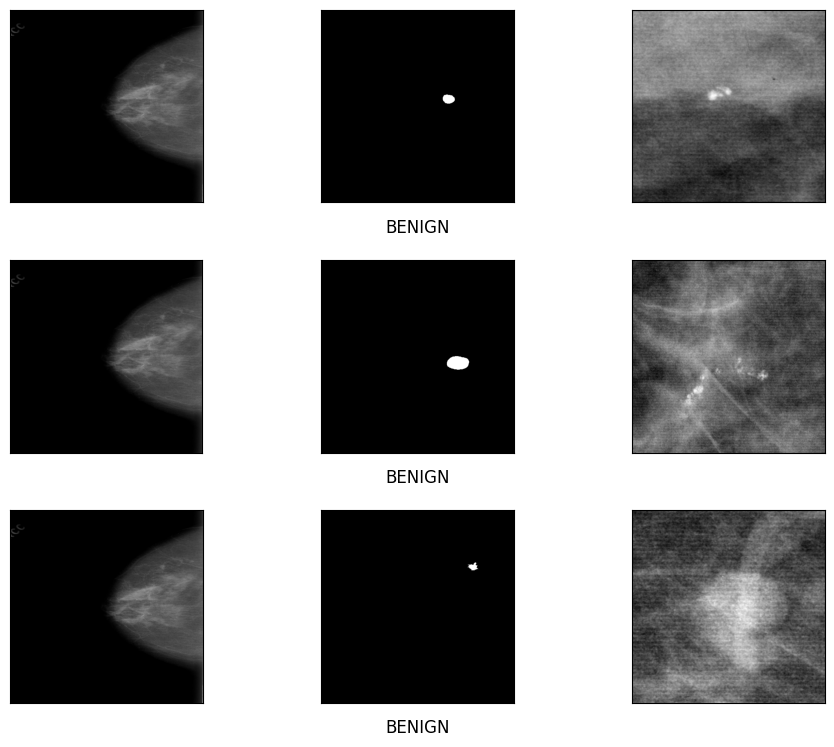

In [ ]:
plot_studies(sample)

#A loop to merge all the masks into a single image

- the new images are then saved with the notation ("M_ID"_mask) into /content/meged_Masks directory

In [ ]:
for idx,row in tqdm(st_segment.iterrows()):
  m_id = row['M_ID']


  masks_df = st_segment[st_segment['M_ID'] == m_id]

  if len(masks_df) == 1:
    continue


  mam_path = row['mammogram_path']
  mam = Image.open(mam_path)
  width = mam.size[0]
  height = mam.size[1]

  merged_mask = np.zeros((height, width), dtype=np.uint8)
  for idx,row in masks_df.iterrows():
    roi_path = row['ROI_path']
    roi = Image.open(roi_path)

    nonzero_indices = np.nonzero(roi)
    merged_mask[nonzero_indices] = 255


  st_segment = st_segment.drop(st_segment[st_segment['M_ID'] == m_id].index)
  merged_image_pil = Image.fromarray(merged_mask)
  merged_path  = f'/content/multi_mask/{m_id}_mask.jpg'
  merged_image_pil.save(f'/content/multi_mask/{m_id}_mask.jpg')

  st_segment = st_segment.append({'M_ID' :  m_id ,'mammogram_path' : mam_path,  'ROI_path': merged_path}, ignore_index=True)


In [ ]:
st_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   M_ID            3032 non-null   object
 1   mammogram_path  3032 non-null   object
 2   ROI_path        3032 non-null   object
dtypes: object(3)
memory usage: 71.2+ KB


3it [00:00,  3.36it/s]


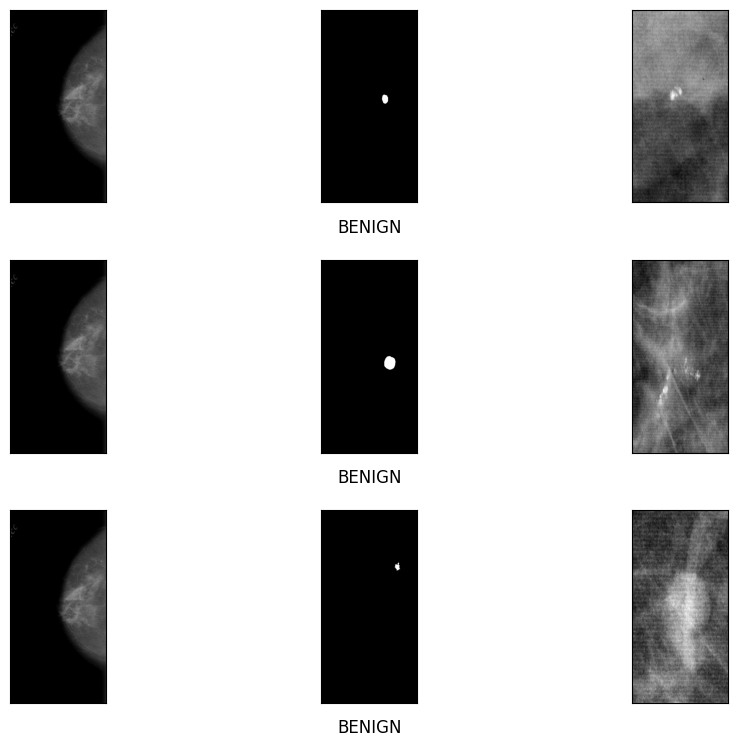

/content/multi_mask/P_00666_RIGHT_CC_mask.jpg


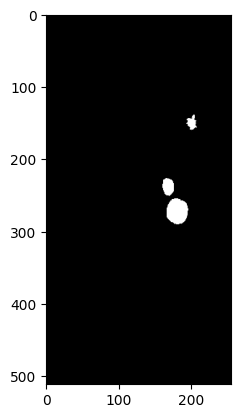

In [ ]:
s_M_ID = sample['M_ID'].iloc[0]

plot_studies(sample)

path =  st_segment[st_segment['M_ID'] == s_M_ID]['ROI_path'].iloc[0]
print(path)
mask = cv2.resize(cv2.imread(path), dsize=(256,512))
plt.imshow(mask)

#Adding Images and Masks to a numpy array

- before adding the images must be normalized around 255 such that it has 0 - 1 input 
- for the masks it should be binary between 0 and 1 
- the image shape will be 255,255,1


In [ ]:
data_length = len(st_segment)

#creating initialize our arrays
IMAGES = np.zeros((data_length, 256,256,1))
MASKS = np.zeros((data_length, 256,256,1))

index = 0 
for idx,row in tqdm(st_segment.iterrows()):

  roi_path = row['ROI_path']
  mam_path = row['mammogram_path']

  img = Image.open(mam_path)
  img = img.resize((256,256),resample=Image.BICUBIC)
  img_array = np.array(img)
  img_array = img_array / 255.0 #normalization

  mask = Image.open(roi_path)
  mask = mask.resize((256,256),resample=Image.BICUBIC)
  mask_array = np.array(mask)
  mask_array = (mask_array > 0).astype(np.uint8)

  IMAGES[index] = img_array.reshape((256,256,1))
  MASKS[index] = mask_array.reshape((256,256,1))
  index = index + 1

3032it [17:54,  2.82it/s]


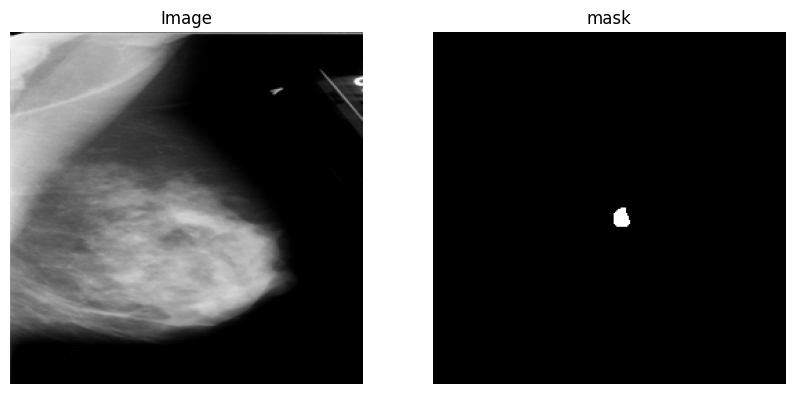

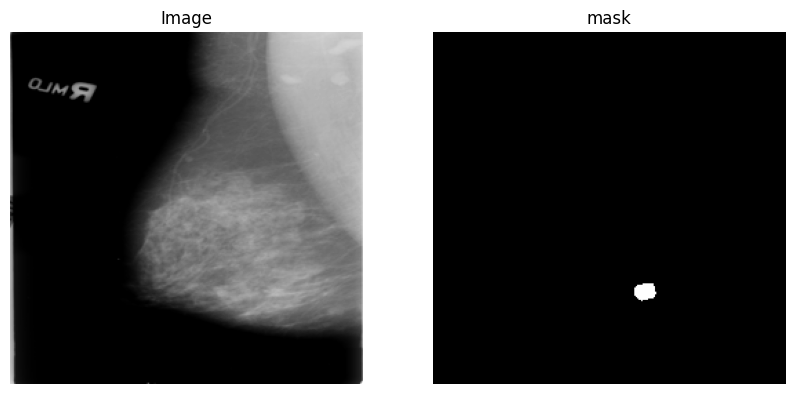

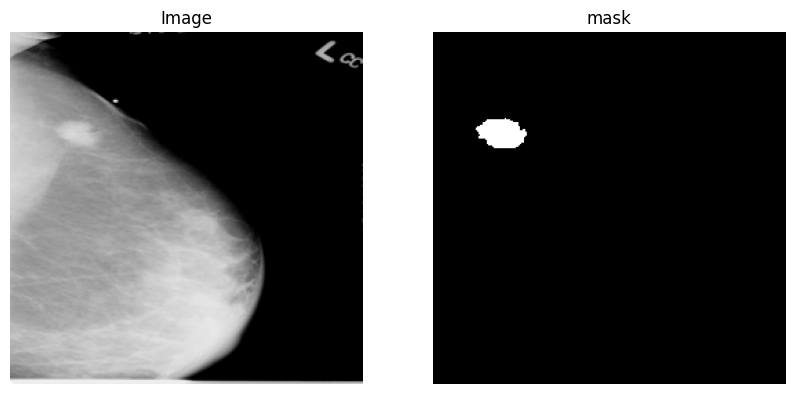

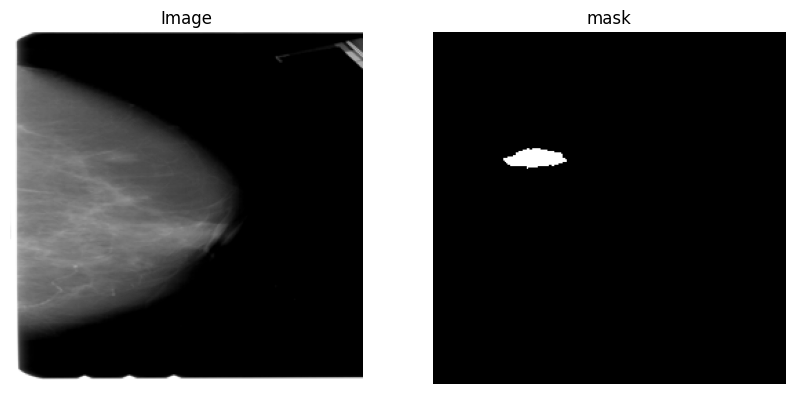

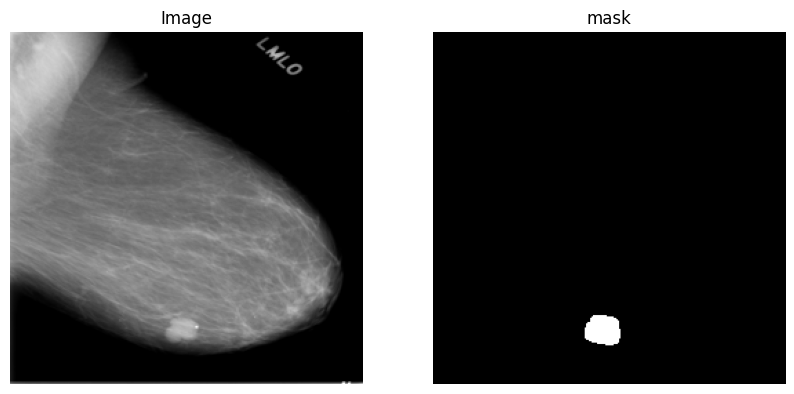

In [ ]:
plot_numpy(IMAGES, MASKS, num_samples= 5)

#Adding Cropped Images and labes into numpy arrays 

- the images will be normalized around 0-1
- the images are 

In [ ]:
st_classify.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3568 entries, 0 to 3603
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   M_ID          3568 non-null   object
 1   cropped_path  3568 non-null   object
 2   pathology     3568 non-null   object
dtypes: object(3)
memory usage: 240.5+ KB


In [ ]:
data_length = len(st_classify)
df = st_classify.copy()

label_mapping = {'BENIGN_WITHOUT_CALLBACK': 0, 'BENIGN': 1, 'MALIGNANT': 2}

df['pathology'] = df['pathology'].map(label_mapping)

df['pathology'] = keras.utils.to_categorical(df['pathology'], num_classes=3)

df = pd.get_dummies(df, columns=['pathology'], prefix='pathology')

# Create and initialize our arrays
CROPPED = np.zeros((data_length, 256, 256, 1))
LABELS = np.zeros((data_length, 3))  # Assuming 3 classes

index = 0
for idx, row in tqdm(df.iterrows()):
    img_path = row['cropped_path']
    label_cols = [col for col in df.columns if 'pathology_' in col]
    label = row[2]  # Assuming the label column is named 'pathology' in your DataFrame

    # Load and resize the image
    img = Image.open(img_path)
    img = img.resize((256, 256), resample=Image.BICUBIC)
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalization

    CROPPED[index] = np.expand_dims(img_array, axis=-1)
    LABELS[index] = label  # Assign the label array to the corresponding index
    index = index + 1


3568it [00:42, 83.41it/s] 


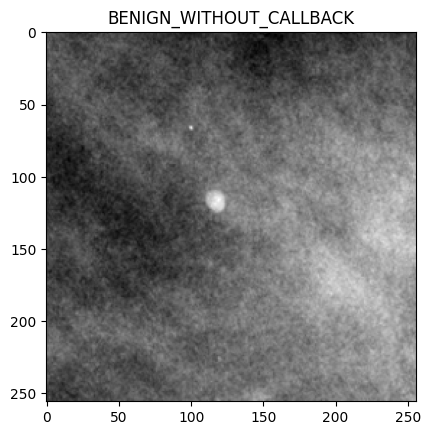

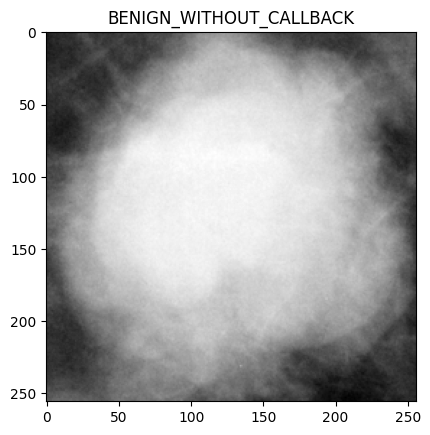

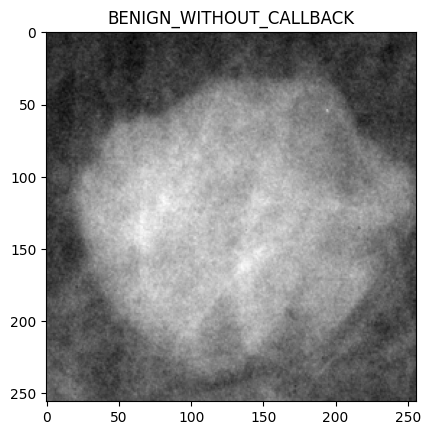

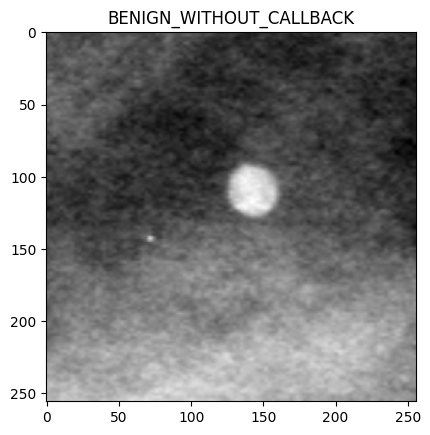

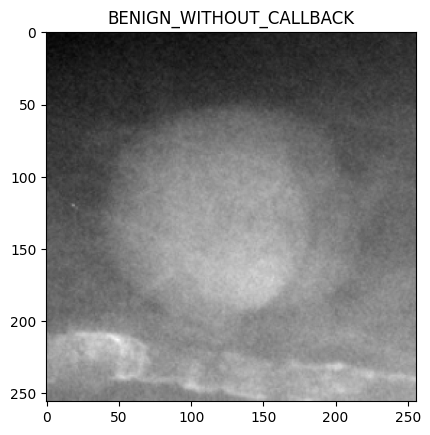

In [ ]:
plot_cropped_numpy(CROPPED,LABELS,num_samples = 5)

#saving

In [ ]:
dir = "/content/drive/MyDrive/Colab Notebooks FINAL/CBIS DDSM pre proccessing/training_data"
np.save(f'{dir}/IMAGES.npy', IMAGES)
np.save(f'{dir}/MASKS.npy', MASKS)
np.save(f'{dir}/CROPPED.npy', CROPPED)
np.save(f'{dir}/CROPPED.npy', LABELS)